# Variational Quantum algorithm for weighted Maxcut on a graph

In [17]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

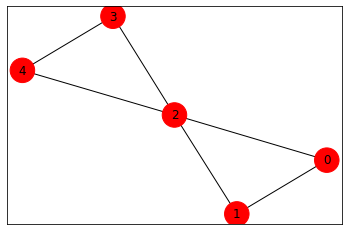

In [18]:
# Generating the butterfly graph with 5 nodes 
n     = 5
V     = np.arange(0,n,1)
E     =[(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0)] 

G     = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

In [19]:
'''
Helper function definitions
'''

def QAOA_state(gamma_list,beta_list,p=1):
    '''
    This function generates the QAOA state |gamma, beta>
    for a given order, p.
    
    '''

    
    circuit = QuantumCircuit(n, n)
    # Apply Hadamard to all of the qubits
    circuit.h(range(0,n))
    circuit.barrier()

    for index in range(p):
                
        for edge in G.edges():
            k,l = edge[0],edge[1]
            
            # U(gamma)
            # control bit to the target bit
            circuit.p(gamma_list[index], k)
            circuit.p(gamma_list[index], l)
            circuit.cp(-2*gamma_list[index], k, l)
            circuit.barrier()
        
        # U(beta)
        circuit.rx(2*beta_list[index], range(n))
        circuit.barrier()
    
    circuit.measure(range(n),range(n))
    
    return circuit



def compute_cost(x,G):
    '''
    Returns the cost of a bitstring x using the max-cut cost function C = sum_{i,j} 1/2*(1-xi*xj)
    
    with xi,xj either -1 or 1
    
    G: Graph object
    x: bitstring consisting of bits that are either 0 or 1.
    '''
    
    #generate a numpy array with -1 or 1 entries from bitstring x
    N=len(x)
    x_transform = np.zeros(N)
    
    for k in range(N):
        x_transform[k] = 2*int(x[k])-1
            
    total_cost=0.0
    
    for edge in G.edges():
        k,l = edge[0],edge[1]
        total_cost+= 0.5*(1.0-x_transform[k]*x_transform[l])
    
    return total_cost



def expectation_value(gamma_list,beta_list,G,p,N_shots=100):
    '''
    Compute the expectation value of the Cost-Hamiltonian 
    
    H_c = 1/2 sum (1-Z_n Z_m)
    on the QAOA basis state |gamma,beta>,
    
    i.e. <gamma betas|H_c|gammas betas>
    
    
    '''
    output=0.0
    
    # Produce the backend
    backend = Aer.get_backend("qasm_simulator")
    
    circuit = QAOA_state(gamma_list,beta_list,p)
    simulate = execute(circuit, backend=backend, shots=N_shots)
    
    results = simulate.result()
    counts = results.get_counts()
    
    for x in counts:
        output += compute_cost(x,G)*(counts[x]/N_shots)
    
    
    return output

In [20]:
from scipy.optimize import minimize


p = 2 # order for the QAOA optimization (trotterization)
N_shots = 10000 # Number of shots to compute the expectation value


def function(z):
    '''
    The expectation value function for the scipy 
    optimizer to optimize
    '''
    
    N = len(z)
    gamma_list = z[0:int(N/2)]
    beta_list = z[int(N/2):N]
    
    f=-expectation_value(gamma_list,beta_list,G,p=int(N/2),N_shots=1000)
    
    return f

# initialize the set of gammas and betas
gamma_list = 2.0*np.pi*np.random.uniform(0,1,p)
beta_list = np.pi*np.random.uniform(0,1,p)


# Minimize the Objective function using the Nelder-Mead algorithm
z0 = np.concatenate((gamma_list,beta_list))
res = minimize(function, z0, method='COBYLA')#,
               #options={'xatol': 1e-2, 'disp': False})


print('QAOA order: ',p)
print('Solution: ', res.x)

QAOA order:  2
Solution:  [4.18705624 5.30762158 0.30724323 2.28908118]


Maximum observed energy:  4.0


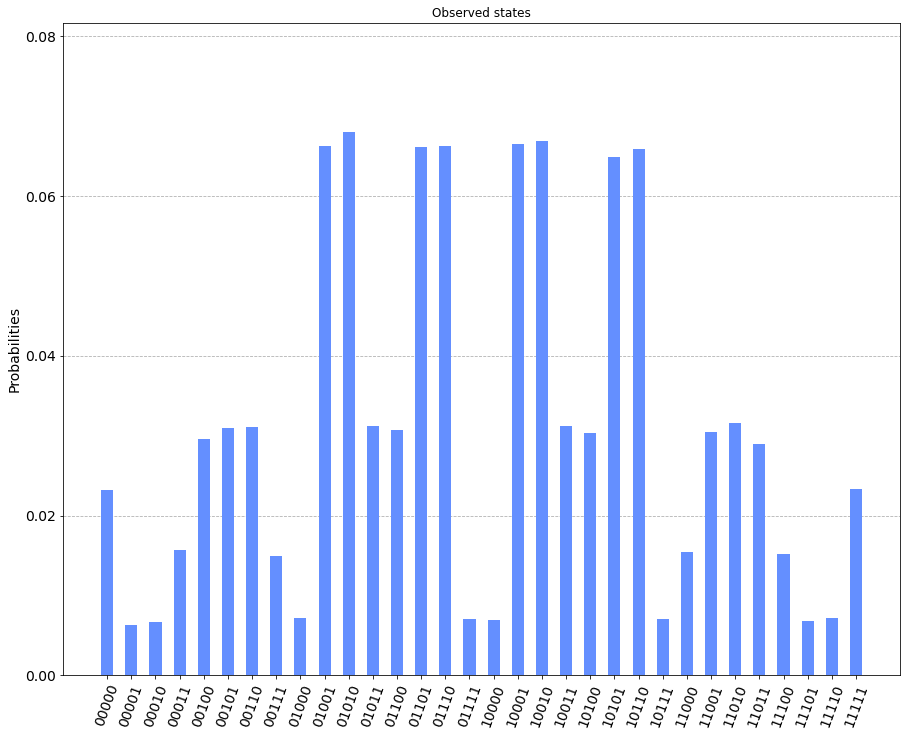

In [21]:
# The number of shots to sample the QAOA wavefunction
N_shots  = 100000


# Extract the optimal parameters for the gamma and beta parameters
gammas_max = res.x[0:p] 
betas_max = res.x[p:2*p]

# retrieve the backend simulator
backend = Aer.get_backend("qasm_simulator")

# Produce the QAOA states and sample the state in the computational basis
circuit = QAOA_state(gammas_max,betas_max,p=p)
simulate = execute(circuit, backend=backend, shots=N_shots)

# retrieve the results from the QAOA
QAOA_results = simulate.result()
counts = QAOA_results.get_counts()

# convert the observed bit-strings into 
x_observed = list(counts.keys())

# Compute the observed energies and keep record of the best solutions
energy_distribution = []

for x in counts:
    energy_distribution.append(compute_cost(x,G))

# Get the maximum observed energy
max_energy = max(energy_distribution)

print('Maximum observed energy: ', max_energy)

max_energy_distributions = []

for k in range(len(counts)):
    Ek = energy_distribution[k]
    
    if(Ek==max_energy):
        max_energy_distributions.append(x_observed[k])
    
# The bitstrings corresponding to the maximium amplitudes
plot_histogram(QAOA_results.get_counts(),
               title='Observed states',
              figsize=(15,12),
              bar_labels=False)


Bitstrings with maximum energy using quantum algorithm:  ['10001', '10010', '10011', '10100', '10101', '10110', '11001', '11010', '11011', '00100', '00101', '00110', '01001', '01010', '01011', '01100', '01101', '01110']


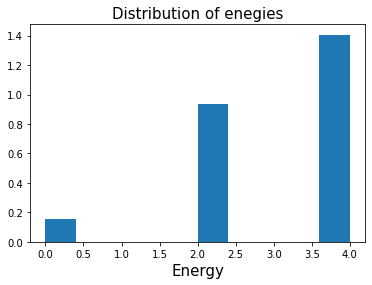

In [22]:
print('Bitstrings with maximum energy using quantum algorithm: ', max_energy_distributions)

plt.title('Distribution of enegies',size=15)
plt.xlabel('Energy', size=15)
plt.hist(energy_distribution,density=True)
plt.show()

## Color plots of solution to the maxcut problem

Solutions to the maxcut problem:


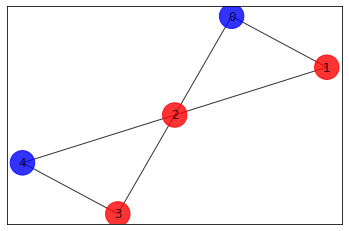

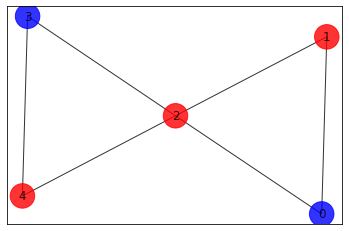

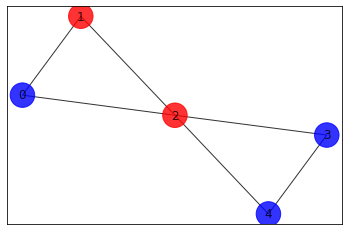

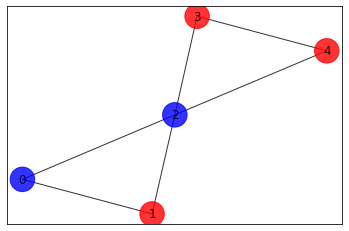

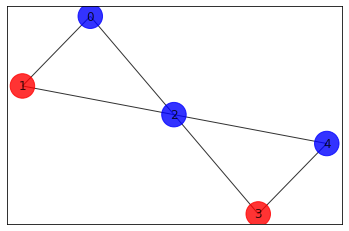

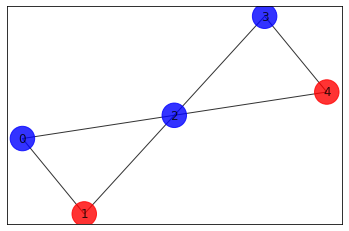

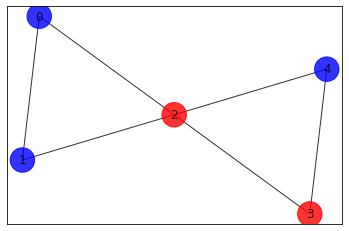

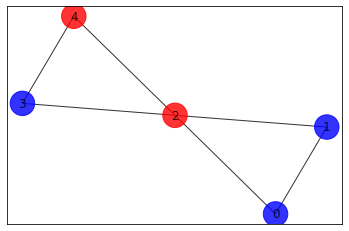

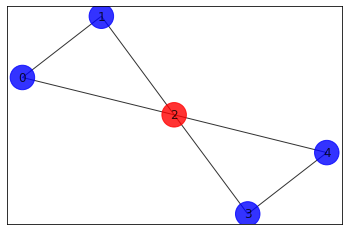

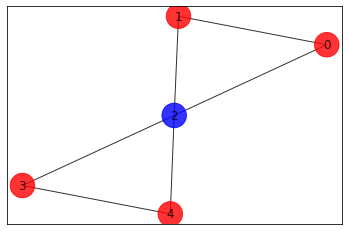

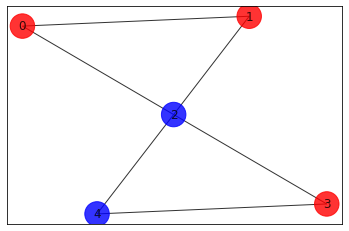

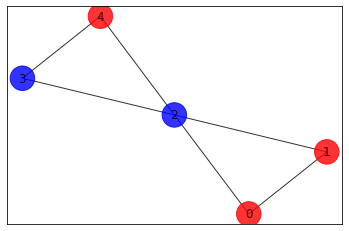

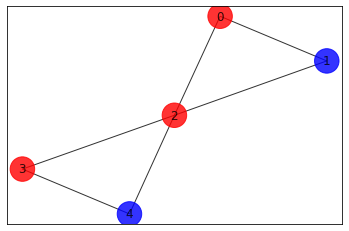

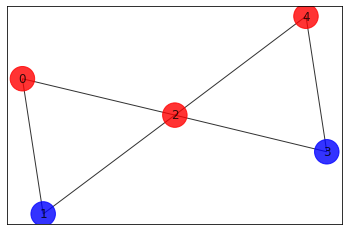

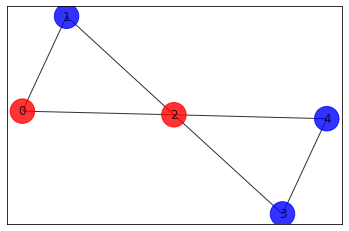

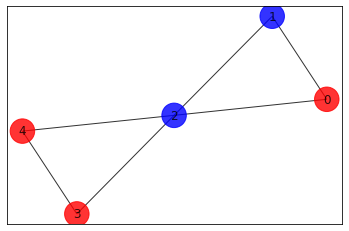

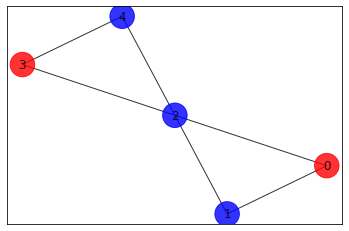

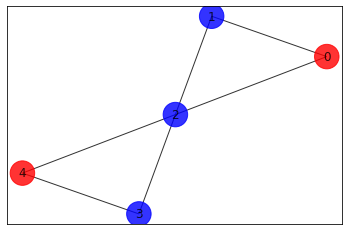

In [24]:
def return_colors(x):
    '''
    Function used to map the bit string to unique colors for
    visualization
    '''
    
    colors = []
    
    for k in range(len(x)):
        
        c = x[k]
        
        if(c=='1'):
            colors.append('b')
        elif(c=='0'):
            colors.append('r')
    
    return colors


print('Solutions to the maxcut problem:')


# Plot all of the solutions to the maxcut problem
for k in range(len(max_energy_distributions)):
    colors = return_colors(max_energy_distributions[k])
    pos = nx.spring_layout(G)
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    plt.show()

## Optimal Maxcut computation using brute force methods

In [26]:
import itertools

perms= ["".join(seq) for seq in itertools.product("01", repeat=n)]

scores = []

for xk in perms:
    Ek = compute_cost(xk,G)
    scores.append(Ek)

# Determine the maximum score
max_E = np.max(scores)

max_strings = []

# Find all energies where this is maximum and store the results
for k in range(len(scores)):
    
    score_k = scores[k]
    xk = perms[k]
    
    if(score_k==max_E):
        max_strings.append(xk)


print('Maximum Energy: ', max_E,'\n')
print('Brute force solutions: {} \n'.format(len(max_strings)),max_strings,'\n')
print('QAOA solutions: {} \n'.format(len(max_energy_distributions)), max_energy_distributions)


# Now we check that all of the solutions match, from QAOA and from brute force

count = 1
wrong_solutions =0
for s in max_energy_distributions:
    
    if(s in max_strings):
        count+=1
    else:
        wrong_solutions+=1


if(count-1 == len(max_strings)):
    print('The QAOA solutions and the brute-force methods match.')
else:
    print('The QAOA algorithm is missing {} solutions.'.format(len(max_strings)-count))
    print('The number of incorrect solutions is: {}'.format(wrong_solutions))

Maximum Energy:  4.0 

Brute force solutions: 18 
 ['00100', '00101', '00110', '01001', '01010', '01011', '01100', '01101', '01110', '10001', '10010', '10011', '10100', '10101', '10110', '11001', '11010', '11011'] 

QAOA solutions: 18 
 ['10001', '10010', '10011', '10100', '10101', '10110', '11001', '11010', '11011', '00100', '00101', '00110', '01001', '01010', '01011', '01100', '01101', '01110']
The QAOA solutions and the brute-force methods match.
